# Práctico Mabwiser

Adaptado de los tutoriales disponibles en: https://github.com/fidelity/mabwiser/tree/master/examples

## Reinforcement Learning

Un agente de RL busca tomar acciones que logren maximizar la ganancia acumulativa.

![RL setup](https://github.com/bamine/recsys-summer-school/raw/12e57cc4fd1cb26164d2beebf3ca29ebe2eab960/notebooks/images/rl-setup.png)


## Exploration vs. Exploitation

Se busca encontrar un balance entre la exploration (decidir tomar una acción para ganar conocimiento) y exploitation (decidir la acción que se calcula que tendrá la mejor ganancia).

![texto alternativo](https://miro.medium.com/max/1400/1*_5dltx4BcI8rRmCK2Sq_kw.png)

## Importar paquetes necesarios

In [ ]:
!pip install mabwiser
# -*- coding: utf-8 -*-

import pandas as pd
from sklearn.preprocessing import StandardScaler

from mabwiser.mab import MAB, LearningPolicy, NeighborhoodPolicy

import random
from mabwiser.simulator import Simulator

from time import time

     |████████████████████████████████| 53 kB 1.5 MB/s 
     |████████████████████████████████| 23.1 MB 1.8 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## Problema con contexto:

Una plataforma de comercio virtual cuenta con 5 _ads_ y quiere determinar cuál de estos generará mayor _revenue_ para un usuario en específico. Para esto, se cuenta con información histórica de _revenues_ obtenidos por otros usuarios en distintos _ads_ junto con la información de la edad, la razón de clicks y si cada usuario es subscriptor o no.

In [ ]:
# Arms
ads = [1, 2, 3, 4, 5]

# Historical data of ad decisions with corresponding revenues and context information
train_df = pd.DataFrame({'ad': [1, 1, 1, 2, 4, 5, 3, 3, 2, 1, 4, 5, 3, 2, 5],
                         'revenues': [10, 17, 22, 9, 4, 20, 7, 8, 20, 9, 50, 5, 7, 12, 10],
                         'age': [22, 27, 39, 48, 21, 20, 19, 37, 52, 26, 18, 42, 55, 57, 38],
                         'click_rate': [0.2, 0.6, 0.99, 0.68, 0.15, 0.23, 0.75, 0.17,
                                        0.33, 0.65, 0.56, 0.22, 0.19, 0.11, 0.83],
                         'subscriber': [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]}
                        )

# Test data to for new prediction
test_df = pd.DataFrame({'age': [37, 52], 'click_rate': [0.5, 0.6], 'subscriber': [0, 1]})
test_df_revenue = pd.Series([7, 13])

# Scale the training and test data
scaler = StandardScaler()
train = scaler.fit_transform(train_df[['age', 'click_rate', 'subscriber']].values.astype('float64'))
test = scaler.transform(test_df.values.astype('float64'))

In [ ]:
########################################################
# KNearest Neighborhood Policy with UCB1 Learning Policy
########################################################

# KNearest context policy with k equals to 5 and ucb1 learning with alpha of 1.25
knearest = MAB(arms=ads,
               learning_policy=LearningPolicy.UCB1(alpha=1.25),
               neighborhood_policy=NeighborhoodPolicy.KNearest(k=5))

# Learn from previous ads shown and revenues generated
knearest.fit(decisions=train_df['ad'], rewards=train_df['revenues'], contexts=train)

# Predict the next best ad to show
prediction = knearest.predict(test)

# Expectation of each ad based on learning from past ad revenues
expectations = knearest.predict_expectations(test)

# Results
print("KNearest: ", prediction, " ", expectations)
assert(prediction == [5, 1])

# Online update of model
knearest.partial_fit(decisions=prediction, rewards=test_df_revenue, contexts=test)

# Updating of the model with new arm
knearest.add_arm(6)

KNearest:  [5, 1]   [{1: 14.5857953014744, 2: 11.242653222492628, 3: 0, 4: 0, 5: 16.5857953014744}, {1: 24.242653222492628, 2: 17.5857953014744, 3: 10.242653222492628, 4: 0, 5: 7.242653222492627}]


### Actividad 1: 
Suponga que a este mismo usuario, se le presenta el nuevo _ad_, $6$, obteniendo un revenue de $40$. Usando el método _partial\_fit_ simule este caso e imprima las nuevas expectations. Comente los resultados obtenidos.

## Problema sin contexto:

El sitio ahora quiere elegir entre dos posibles opciones de diseño para su _homepage_. Para esto tiene datos históricos del revenue aportado por cada diseño, pero no cuenta con ningún dato acerca de los usuarios.

In [ ]:
# Arms
options = [1, 2]

# Historical data of layouts decisions and corresponding rewards
layouts = [1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1]
revenues = [10, 17, 22, 9, 4, 0, 7, 8, 20, 9, 50, 5, 7, 12, 10]

In [ ]:
###################################
# Epsilon Greedy Learning Policy
###################################

# Epsilon Greedy learning policy with random exploration set to 15%
greedy = MAB(arms=options,
             learning_policy=LearningPolicy.EpsilonGreedy(epsilon=0.15),
             seed=123456)

# Learn from previous layouts decisions and revenues generated
greedy.fit(decisions=layouts, rewards=revenues)

# Predict the next best layouts decision
prediction = greedy.predict()

# Expected revenues of each layouts learnt from historical data based on epsilon greedy policy
expectations = greedy.predict_expectations()

# Results
print("Epsilon Greedy: ", prediction, " ", expectations)
# assert(prediction == 1)

# Additional historical data becomes available which allows _online learning
additional_layouts = [1, 2, 1, 2]
additional_revenues = [0, 12, 7, 19]

# Online updating of the model
greedy.partial_fit(additional_layouts, additional_revenues)

Epsilon Greedy:  2   {1: 10.875, 2: 14.714285714285714}


### Actividad 2:
Suponga que en un experimento online, se le muestra a un usuario ambos diseños y el _revenue_ obtenido es exactamente el estimado por el agente. ¿Qué esperaría que pase al actualizar el modelo? Simule este caso en $5$ iteraciones, imprimiendo las expectations. Comente los resultados observados.

* Learning policies:
 * Epsilon Greedy
 * LinTS
 * LinUCB
 * Popularity
 * Random
 * Softmax
 * Thompson Sampling (TS)
 * Upper Confidence Bound (UCB1)

* Neighborhood Policies
 * Clusters
 * K-Nearest
 * LSH Nearest
 * Radius
 * TreeBandit

## Simulación:

Vamos a simular un multi-armed bandits para un dataset aleatorio con $1000$ entradas de datos y comparar los rendimientos de cada learning-policy:

In [ ]:
size = 1000

decisions = [random.randint(0, 2) for _ in range(size)]
rewards = [random.randint(0, 1000) for _ in range(size)]
contexts = [[random.random() for _ in range(50)] for _ in range(size)]

In [ ]:
####################################
# Different Bandits for Simulation
####################################

print('Starting simulation 1\n')


def binarize(decision, reward):

    return reward >= 500

n_jobs=2
contextual_mabs = [('Random', MAB([0, 1], LearningPolicy.Random(), NeighborhoodPolicy.Radius(10), n_jobs=n_jobs)),
                   ('UCB1', MAB([0, 1], LearningPolicy.UCB1(1), NeighborhoodPolicy.Radius(10), n_jobs=n_jobs)),
                   ('ThompsonSampling', MAB([0, 1], LearningPolicy.ThompsonSampling(binarize),
                                            NeighborhoodPolicy.Radius(10), n_jobs=n_jobs)),
                   ('EpsilonGreedy', MAB([0, 1], LearningPolicy.EpsilonGreedy(epsilon=.15),
                                         NeighborhoodPolicy.Radius(10), n_jobs=n_jobs)),
                   ('Softmax', MAB([0, 1], LearningPolicy.Softmax(), NeighborhoodPolicy.Radius(10), n_jobs=n_jobs))]

context_free_mabs = [('Random', MAB([0, 1], LearningPolicy.Random(), n_jobs=n_jobs)),
                     ('UCB1', MAB([0, 1], LearningPolicy.UCB1(1), n_jobs=n_jobs)),
                     ('ThompsonSampling', MAB([0, 1], LearningPolicy.ThompsonSampling(binarize), n_jobs=n_jobs)),
                     ('EpsilonGreedy', MAB([0, 1], LearningPolicy.EpsilonGreedy(epsilon=.15), n_jobs=n_jobs)),
                     ('Softmax', MAB([0, 1], LearningPolicy.Softmax(), n_jobs=n_jobs))]

Starting simulation 1



2021-10-23 19:12:40,619 INFO Simulation Parameters
2021-10-23 19:12:40,621 INFO 	 bandits: [('Random', <mabwiser.mab.MAB object at 0x7fbcc87b3cd0>), ('UCB1', <mabwiser.mab.MAB object at 0x7fbcc87b38d0>), ('ThompsonSampling', <mabwiser.mab.MAB object at 0x7fbcc87b3e10>), ('EpsilonGreedy', <mabwiser.mab.MAB object at 0x7fbcc87b3ed0>), ('Softmax', <mabwiser.mab.MAB object at 0x7fbcc87b3f90>)]
2021-10-23 19:12:40,622 INFO 	 scaler: None
2021-10-23 19:12:40,623 INFO 	 test_size: 0.5
2021-10-23 19:12:40,628 INFO 	 is_ordered: False
2021-10-23 19:12:40,630 INFO 	 batch_size: 0
2021-10-23 19:12:40,633 INFO 	 evaluator: <function default_evaluator at 0x7fbccedcf680>
2021-10-23 19:12:40,635 INFO 	 seed: 123456
2021-10-23 19:12:40,637 INFO 	 is_quick: False
2021-10-23 19:12:40,639 INFO 	 log_file: None
2021-10-23 19:12:40,641 INFO 	 format: %(asctime)s %(levelname)s %(message)s
2021-10-23 19:12:40,645 INFO 

2021-10-23 19:12:40,647 INFO Total Stats
2021-10-23 19:12:40,649 INFO {0: {'count': 310, 

Complete 0.010185941060384115 minutes


Random
Worst Case Scenario: {0: {'count': 269, 'sum': 42004, 'min': 4, 'max': 958, 'mean': 156.14869888475837, 'std': 279.36967056729617}, 1: {'count': 231, 'sum': 45636, 'min': 8, 'max': 991, 'mean': 197.55844155844156, 'std': 304.34214740728953}}
Average Case Scenario: {0: {'count': 269, 'sum': 128675.31764705881, 'min': 28.0, 'max': 958.0, 'mean': 478.346905751148, 'std': 157.26001279928406}, 1: {'count': 231, 'sum': 110231.24844720497, 'min': 8.0, 'max': 991.0, 'mean': 477.19155171950206, 'std': 183.15924196618118}}
Best Case Scenario: {0: {'count': 269, 'sum': 229252, 'min': 28, 'max': 1000, 'mean': 852.2379182156134, 'std': 273.85020715708515}, 1: {'count': 231, 'sum': 187881, 'min': 8, 'max': 991, 'mean': 813.3376623376623, 'std': 292.05953006369924}}



UCB1
Worst Case Scenario: {0: {'count': 500, 'sum': 72373, 'min': 4, 'max': 996, 'mean': 144.746, 'std': 273.95137795601613}, 1: {'count': 0, 'sum': nan, 'min': nan, 'max': nan, 'mean': na

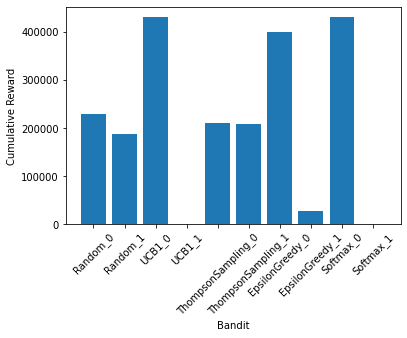

In [ ]:
####################################
# Context-Free Simulation
####################################
start = time()
sim = Simulator(context_free_mabs, decisions, rewards, contexts=None,
                scaler=None, test_size=0.5, is_ordered=False, batch_size=0, seed=123456)
sim.run()
end = time()

runtime = (end - start) / 60
print('Complete', str(runtime) + ' minutes')
print('\n')

for mab_name, mab in sim.bandits:
    print(mab_name)

    print('Worst Case Scenario:', sim.bandit_to_arm_to_stats_min[mab_name])
    print('Average Case Scenario:', sim.bandit_to_arm_to_stats_avg[mab_name])
    print('Best Case Scenario:', sim.bandit_to_arm_to_stats_max[mab_name])

    print('\n\n')

sim.plot('max', True) 
# Vamos a plotear el best case scenario para todos los bandidos utilizados. El parámetro True indica que en el plot se va a plotear por separado cada "brazo"

### Actividad 3: Simulación "on-line" con contexto.

Basándose en el código anterior, vamos a repetir este experimento para los bandidos con contexto definidos anteriormente. Recuerde que los datos de contextos deben ser escalados, por lo que debe cambiar el parámetro scaler.

Esta simulación, a diferencia de la anterior, simulará un agente que se va actualizando de manera "on-line", en donde en cada iteración, los agentes reciben $100$ datos y en base a estos, actualizan sus políticas. Para hacer esto, solo debe modificar el parámetro de batch-size. Comente sus resultados

In [ ]:
start = time()
sim = # Rellenar
sim.run()
end = time()

runtime = (end - start) / 60
print('Complete', str(runtime) + ' minutes')
print('\n')

for mab_name, mab in sim.bandits:
    print(mab_name)

    # Como esta simulación es online, se debe específicar que imprima el valor 'total'
    print('Worst Case Scenario:', sim.bandit_to_arm_to_stats_min[mab_name]['total'])
    print('Average Case Scenario:', sim.bandit_to_arm_to_stats_avg[mab_name]['total'])
    print('Best Case Scenario:', sim.bandit_to_arm_to_stats_max[mab_name]['total'])

    print('\n\n')

sim.plot('avg', False)
# Como buscamos ahora maximizar el revenue, no separaremos los resultados por brazo, sino que se graficará de manera conjunta el revenue promedio obtenido por cada agente.

SyntaxError: ignored